In [1]:
import tensorflow as tf
import json
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from preprocess import Preprocessor
import numpy as np
import cv2
from hourglass104 import StackedHourglassNetwork

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

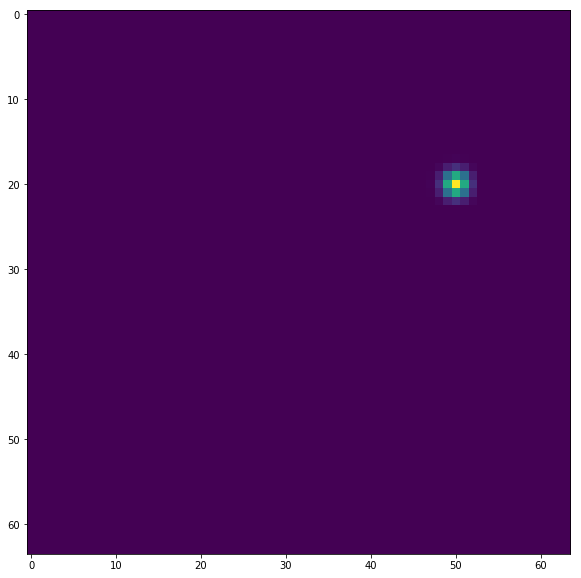

In [4]:
plt.rcParams['figure.figsize'] = (10,10)

p = Preprocessor(is_train=True)
h = p.generate_2d_guassian(64, 64, 20, 50)

plt.imshow(h, cmap='viridis', interpolation='nearest')
plt.show()

In [5]:
def parse_tfexample(example_proto):
    image_feature_description = {
        'image/height': tf.io.FixedLenFeature([], tf.int64),
        'image/width': tf.io.FixedLenFeature([], tf.int64),
        'image/depth': tf.io.FixedLenFeature([], tf.int64),
        'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
        'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
        'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
        'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
        'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
        'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/filename': tf.io.FixedLenFeature([], tf.string),
    }
    return tf.io.parse_single_example(example_proto,
                                      image_feature_description)

def parse(example):
    features = parse_tfexample(example)
    image = tf.io.decode_jpeg(features['image/encoded'])
    image, keypoint_x, keypoint_y = p.crop_roi(image, features)
#     keypoint_x = tf.cast(tf.sparse.to_dense(features['image/object/parts/x']), dtype=tf.int32)
#     keypoint_y = tf.cast(tf.sparse.to_dense(features['image/object/parts/y']), dtype=tf.int32)
    return image, keypoint_x, keypoint_y

dataset2 = tf.data.Dataset.list_files('./dataset/tfrecords_mpii/train*.tfrecords')
dataset2 = tf.data.TFRecordDataset(dataset2)
dataset2 = dataset2.map(parse)

In [6]:
for image, keypoint_x, keypoint_y in dataset2.take(1):
    x = keypoint_x.numpy()
    y = keypoint_y.numpy()
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    tf.io.write_file('test2.jpg', tf.io.encode_jpeg(image))
    for joint in zip(x, y):
        if joint[0] < 0 or joint[1] < 0:
            continue
        plt.scatter(joint[0] * image.shape[1], joint[1] * image.shape[0], s=10, c='red', marker='o')
    plt.show()

InvalidArgumentError: Key: image/object/parts/y.  Data types don't match. Expected type: int64, Actual type: float
	 [[{{node ParseSingleExample/ParseExample/ParseExampleV2}}]]

In [ ]:
tf.random.uniform([1], 0.1, 0.3)[0]

In [9]:
p = Preprocessor(is_train=True)
dataset = tf.data.Dataset.list_files('./dataset/tfrecords_mpii/train*.tfrecords')
dataset = tf.data.TFRecordDataset(dataset)
dataset = dataset.map(p)

images = []
heatmaps = [] 
for image, heatmap in dataset.take(5):
    images.append(image.numpy())
    heatmaps.append(heatmap.numpy())

In [10]:
for image, heatmap in zip(images, heatmaps):
    image = (image + 1) * 127.5
    
    image = cv2.resize(image.astype(np.uint8), dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
#     plt.imshow(image)
#     plt.show()
    combined_map = np.amax(heatmap, axis=2) * 255
    heatmap_image = cv2.applyColorMap(combined_map.astype(np.uint8), cv2.COLORMAP_JET)
#     plt.imshow(heatmap_image)
#     plt.show()
    overlayed = cv2.addWeighted(heatmap_image, 0.5, image, 0.5, 0)
    plt.imshow(overlayed)
    plt.show()

In [11]:
heatmap_array = tf.TensorArray(tf.int32, 2)

for i in range(2):
    heatmap_array = heatmap_array.write(i, tf.convert_to_tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9]]))

heatmaps = heatmap_array.stack()
heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0])
print(heatmaps)

tf.Tensor(
[[[1 1]
  [2 2]
  [3 3]]

 [[4 4]
  [5 5]
  [6 6]]

 [[7 7]
  [8 8]
  [9 9]]], shape=(3, 3, 2), dtype=int32)
